In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
pip install python-docx

**Approach**


1.   Use a pre-trained model to encode all the frames and generate embedding vectors.
2.   Apply dimensionality reduction algorithm(PCA) to the embedding vectors.
3. Using elbow method to find optimal k for clustering.
4. Use K-means clustering algorithm to cluster all the frames.
5. Find the closest frame to each cluster.




**Hyper Parameters**

*   K - number of clusters -- Used Elbow method to determine the value of this parameter
*   Number of iterations for K-means -- Chosen based on computational cost
*   Number of components for PCA -- Chosen based on computational cost



In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.preprocessing import image
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_BREAK
import os
from PIL import Image



%matplotlib inline

**1. Use a pre-trained model to encode all the frames**

In [0]:
videoPath = "/content/drive/My Drive/Testing Videos/Test Video 4.mp4"

In [0]:

#Function to read all the frames from a given video
def read_frames(video_path):
  frameList = []
  cap = cv2.VideoCapture(videoPath)
  while(True):
    ret,frame = cap.read()
    if ret:
      frameList.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    else:
      break
      
  return frameList

#function to calculate timestamp of each frame
def get_timestamp(videoPath):
  cap = cv2.VideoCapture(videoPath)
  fps = cap.get(cv2.CAP_PROP_FPS)

  timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
  calcTimestamps = [0.0]

  while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:     
      timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))
      calcTimestamps.append((calcTimestamps[-1] + 1000/fps))
    else:
        break

  cap.release()
  return calcTimestamps

#Function to resize the frame to (224,224,3)
def resize_frame(frameList):
  X = []
  for frame in frameList:
    a = resize(frame,preserve_range=True,output_shape=(224,224)).astype(int)
    X.append(a)

  return X
    

In [0]:
calcTimestamps = get_timestamp(videoPath)

In [0]:
frameList = read_frames(videoPath)
totalFrames = len(frameList)


In [163]:
print(len(frameList))
print(frameList[1].shape)

3853
(360, 640, 3)


In [0]:
#resize input to (224,224,3)
X = resize_frame(frameList)

<class 'list'>
(224, 224, 3)


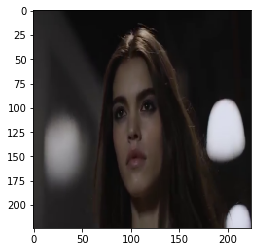

In [165]:
print(type(X))
print(X[0].shape)
plt.rcParams["axes.grid"] = False
plt.imshow(X[1000])

In [0]:
#preprocess input
X = np.array(X)
X = preprocess_input(X,mode='tf')

#create a base model
base_model = VGG19(weights='imagenet',include_top=False,
                  input_shape=(224,224,3))

#extract image embeddings from pre-trained model
X = base_model.predict(X)

**2. Use PCA to reduce the dimensions of extracted features.**

In [0]:
#reshape X
X = X.reshape((-1,7*7*512))

In [0]:
pca = PCA(n_components=128,
         random_state = 234,
         svd_solver = 'auto'
         )

X_pca = pca.fit_transform(X)

In [169]:
X_pca.shape

(3853, 128)

**3. Using elbow method to find optimal k for clustering.**

In [0]:
cost = []

for i in range(10,100):
  KM  =  KMeans(n_clusters=i,max_iter = 500)
  KM.fit(X_pca)
  
  cost.append(KM.inertia_)

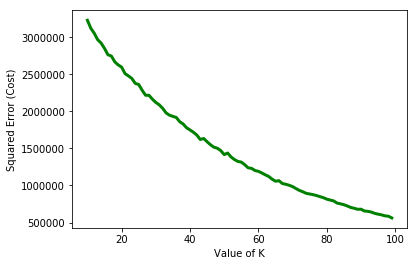

In [171]:
plt.plot(range(10,100),cost,color='g',linewidth='3')
plt.yscale('linear')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

**4. Use K-means clustering algorithm to cluster all the frames.**

In [0]:
  n_clusters = 70
  score = 1000000

In [0]:
KM = KMeans(n_clusters=n_clusters,max_iter=500)
KM.fit(X_pca)
cost.append(KM.inertia_)
cluster_centers = KM.cluster_centers_
labels = KM.labels_

In [174]:
print(type(cluster_centers))
print(cluster_centers.shape)
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(70, 128)
<class 'numpy.ndarray'>
(3853,)


**5. Finding the closest frame to each cluster.**

In [0]:
dist = []
indices = []
for i in range(n_clusters):
  min_dist = sys.maxsize
  index = -1
  for j in range(totalFrames):
    if(np.sum(np.square(cluster_centers[i,:] - X_pca[j,:])) < min_dist):
      min_dist = np.sum(np.square(cluster_centers[i,:] - X_pca[j,:]))
      index = j
      pass
    pass
  indices.append(index)
  dist.append(min_dist)
   

In [176]:
indices[:10]

[3361, 2305, 29, 3719, 318, 2640, 2983, 1134, 2143, 880]

In [177]:
key_frames = []
for i in sorted(indices):
  key_frames.append(frameList[i])
  
print(len(key_frames))

70


IndexError: ignored

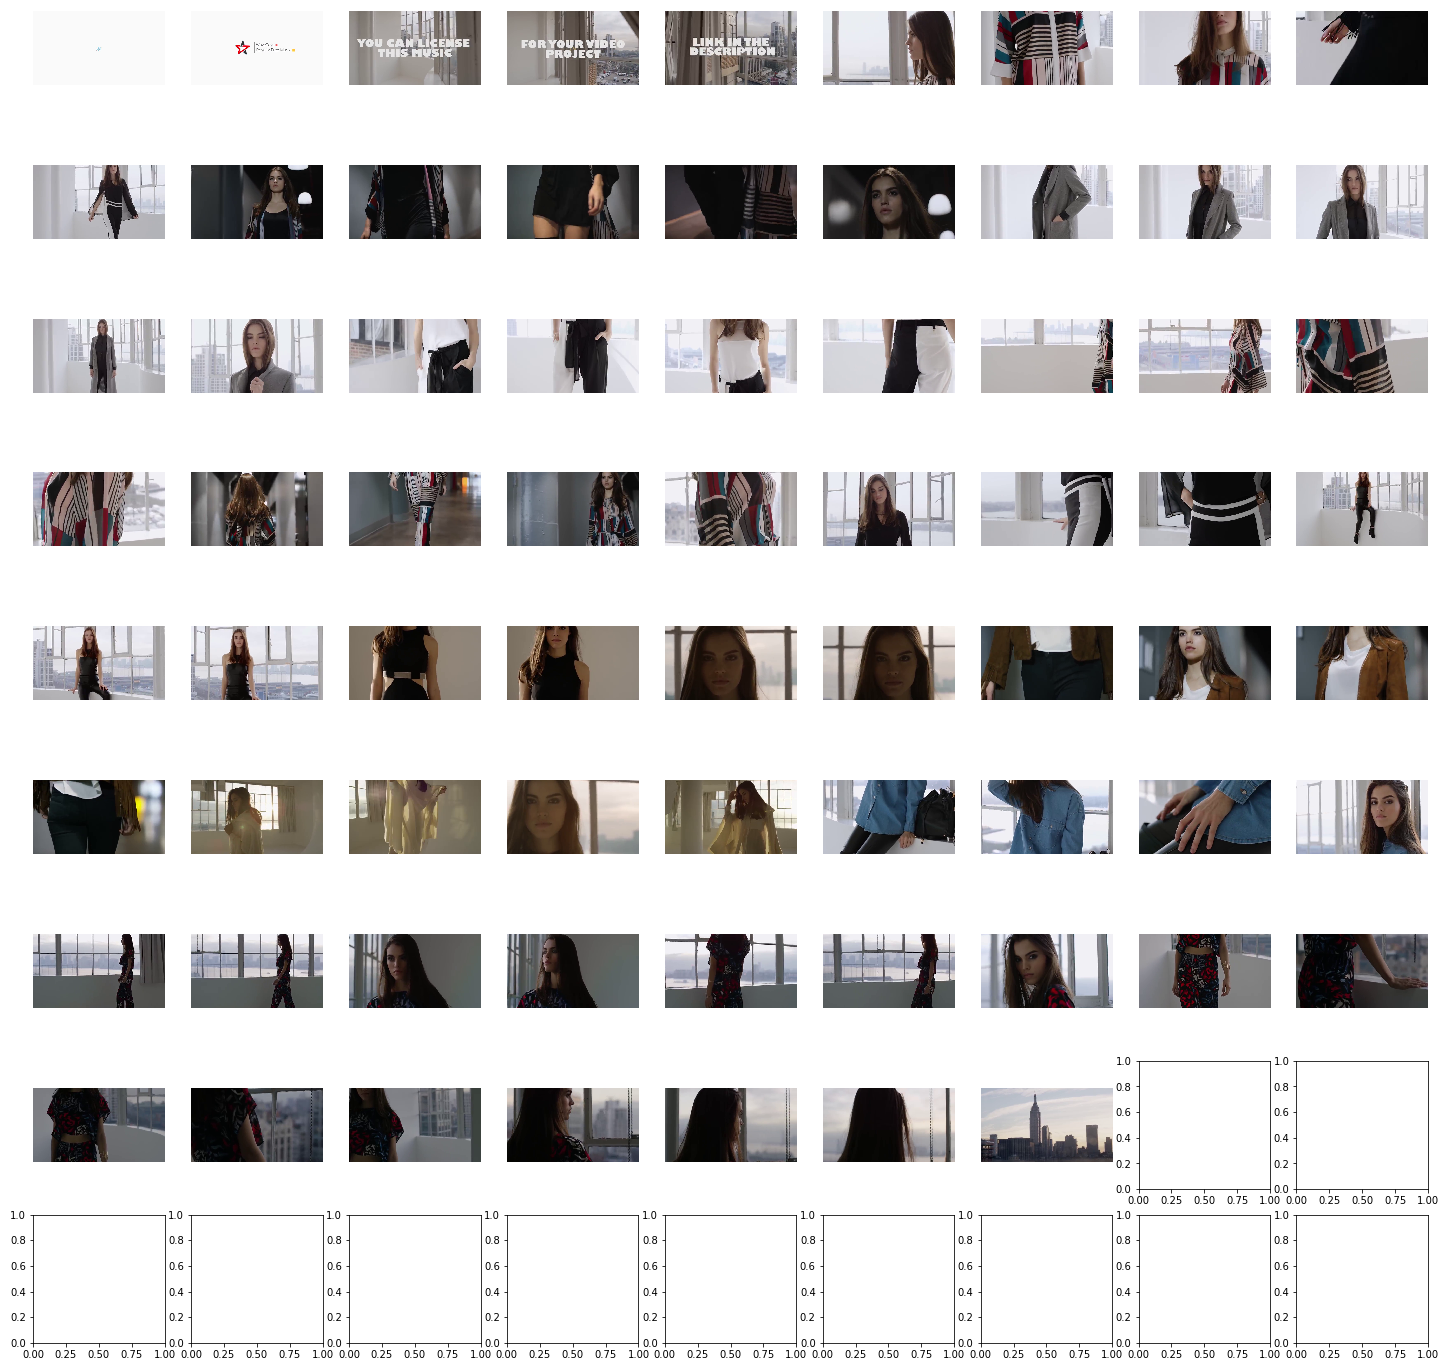

In [178]:
plt.rcParams["axes.grid"] = False

grid_size = int(np.ceil(np.sqrt(n_clusters)))

f, axarr = plt.subplots(grid_size,grid_size,figsize=(25, 25))

for i in range(grid_size):
  for j in range(grid_size):
    axarr[i,j].imshow(key_frames[grid_size*i + j])
    axarr[i,j].axis('off')


**Code to generate test file**

In [0]:
def get_data(filename):
    document = Document(filename)
    fullText = []
    for para in document.paragraphs:
        fullText.append(para.text)
    document.save(filename)
    return '\n'.join(fullText)
  
  
def add_frame_time(document,indices,calcTimestamps):
  p = document.add_paragraph()
  r = p.add_run()
  for index in indices:
    frameMin =(calcTimestamps[index]/(1000*60))%60
    frameMin = round(frameMin,2)
    r.add_text("Time = ")
    r.add_text(str(frameMin))
    r.add_text(' ')
    pass
  
def add_frame_number(document,textList):
  p = document.add_paragraph()
  r = p.add_run()
  for text in textList:
    r.add_text("Frame No. : ")
    r.add_text(str(text))
    r.add_text(' ')
    pass  

def add_initial_data(document,videoName,time,totalKeyFrames,score):
  p = document.add_paragraph()
  r = p.add_run()
  r.add_text(videoName)
  r.add_text(',')
  r.add_text('Video Processing Time = ' + str(time))
  r.add_text(',')
  r.add_text('Key Frames Extracted = ' + str(totalKeyFrames))
  r.add_text(',')
  r.add_text('Evaluation Metric = Inertia')
  r.add_text(',')
  r.add_text('Metric Score = '+str(score))
  

def add_pic(document,frameList):
  size = (80,80)
  p = document.add_paragraph()
  r = p.add_run()
  for frame in frameList:
    im = Image.fromarray(frame)
    im.thumbnail(size)
    name = 'image' + str(i) + '.png'
    im.save(name)
    r.add_picture(name)
    r.add_text(' ')
    
  
def add_data(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames,document):
  size = (80,80)
  p = document.add_paragraph()
  r = p.add_run()
  time = (calcTimestamps[totalFrames]/(1000*60))%60
  time = round(time,2)
  indices = sorted(indices)
  totalKeyFrames = len(key_frames)
  add_initial_data(document,videoName,time,totalKeyFrames,score)
  r.add_break(WD_BREAK.LINE)
  num = totalKeyFrames // 5
  rem = totalKeyFrames - num
  for i in range(num):
    add_frame_number(document,indices[i*5:i*5+5])
    r.add_break(WD_BREAK.LINE)
    add_frame_time(document,indices[i*5:i*5+5],calcTimestamps)
    r.add_break(WD_BREAK.LINE)    
    add_pic(document,key_frames[i*5:i*5+5])
    r.add_break(WD_BREAK.LINE)
    pass 
  add_frame_number(document,indices[num*5:])
  r.add_break(WD_BREAK.LINE)
  add_frame_time(document,indices[num*5:],calcTimestamps)
  r.add_break(WD_BREAK.LINE)
  add_pic(document,key_frames[num*5:])
  r.add_break(WD_BREAK.LINE)
  document.save('test.docx')
   
def generateTestFile(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames):
  if os.path.isfile(fileName):
    data = get_data(fileName)
    document = Document(fileName)
    p = document.add_paragraph()
    r = p.add_run()
    r.add_text(data)
    add_data(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames,document)
  else:
    document = Document()
    add_data(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames,document)
    

In [0]:
#generate test file
videoName = 'Test Video 4'
generateTestFile('test.docx',key_frames,videoName,score,indices,calcTimestamps,totalFrames)